In [6]:
import numpy as np
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [7]:
train_pos = "hotelPosT-train-Copy1.txt"
train_neg = "hotelNegT-train-Copy1.txt"

### Get word counts

In [10]:
def count_words(txt_file):
    '''
    Join all the reviews in a file and count occurences of each unigram.
    '''
    with open(txt_file, "r") as infile:
        reviews = infile.readlines()
    
    count_r = 0
    split_reviews = []
    for r in reviews:    
        count_r += 1
        review = re.sub("[,.!?]", "", r)
        review = review.lower().split()
        split_reviews += review[1:]
        
    return split_reviews, Counter(split_reviews), count_r

words_list_pos, word_counts_pos, review_count_pos = count_words(train_pos)
words_list_neg, word_counts_neg, review_count_neg = count_words(train_neg)

In [11]:
review_count_pos, review_count_neg

(84, 83)

In [13]:
# For smoothing later: size of set of unique words
V = len(set(words_list_neg+words_list_pos))
V

2958

In [14]:
count_pos = len(words_list_pos)
count_neg = len(words_list_neg)
total_words = count_pos + count_neg
len(words_list_pos), len(words_list_neg), total_words

(9926, 9303, 19229)

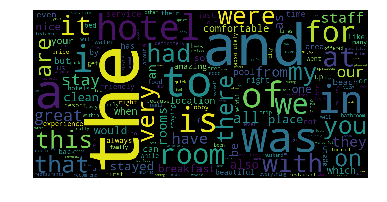

In [15]:
wordcloud1 = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_counts_pos)
plt.imshow(wordcloud1); plt.axis("off"); plt.show()

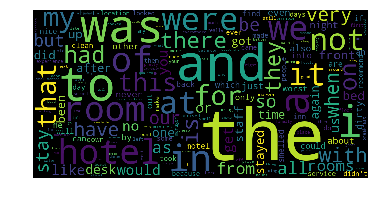

In [16]:
wordcloud2 = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_counts_neg)
plt.imshow(wordcloud2); plt.axis("off"); plt.show()

For a given review, each word is an input feature (i.e. $x_i$): <br>

$$ P(y|x_1,...,x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i|y)}{P(x_1,...,x_n)} $$

For each review:
1. Split text into unigrams
2. Get $P(y)$ - total number of words in a review type / total number of words
3. Get $P(x_i|y)$ - number of each word in review / total number of words in a review type
4. Multiple 2 and 3.

### Calculate probabilities

In [17]:
test_review = "ID-1210	Went to this hotel when visiting nearby national parks with family. Front desk staff was courteous and quickly resolved any questions we had. Our 2-queen bed room was clean and spacious. Room has nice LCD TV, coffee maker, fridge, microwave, massaging shower heads, and good mattresses. We stayed for 2 nights and room was well cleaned and put together after first night with coffee packs refilled. Overall very satisfied."
test_review = re.sub("[,.!]", "", test_review)
test_review = test_review.lower().split()
test_review

['id-1210',
 'went',
 'to',
 'this',
 'hotel',
 'when',
 'visiting',
 'nearby',
 'national',
 'parks',
 'with',
 'family',
 'front',
 'desk',
 'staff',
 'was',
 'courteous',
 'and',
 'quickly',
 'resolved',
 'any',
 'questions',
 'we',
 'had',
 'our',
 '2-queen',
 'bed',
 'room',
 'was',
 'clean',
 'and',
 'spacious',
 'room',
 'has',
 'nice',
 'lcd',
 'tv',
 'coffee',
 'maker',
 'fridge',
 'microwave',
 'massaging',
 'shower',
 'heads',
 'and',
 'good',
 'mattresses',
 'we',
 'stayed',
 'for',
 '2',
 'nights',
 'and',
 'room',
 'was',
 'well',
 'cleaned',
 'and',
 'put',
 'together',
 'after',
 'first',
 'night',
 'with',
 'coffee',
 'packs',
 'refilled',
 'overall',
 'very',
 'satisfied']

In [18]:
# These are P(class): FIX: count(id's in a class / total id's)
# prob_pos = count_pos / total_words
# prob_neg = count_neg / total_words
prob_pos = review_count_pos / (review_count_pos + review_count_neg)
prob_neg = review_count_neg / (review_count_pos + review_count_neg)
prob_pos, prob_neg

(0.5029940119760479, 0.49700598802395207)

In [19]:
count_pos, count_neg

(9926, 9303)

In [20]:
def predict_class(review, class_prob, class_count, V, word_counts):
    prediction = 0
    for word in review[1:]:
        # Compute conditional prob in log space
        word_count = word_counts[word] + 1
        prob_word_given_class = np.log((word_count) / (class_count + V))
        prediction += prob_word_given_class
    return prediction + np.log(class_prob)

pos = predict_class(test_review, prob_pos, count_pos, V, word_counts_pos)
neg = predict_class(test_review, prob_neg, count_neg, V, word_counts_neg)
pos, neg, pos > neg

(-455.63421316814674, -470.55540210188997, True)

In [21]:
def make_decision(review, predict_class):
    # Compute probabilities for positive and negative classes
    predict_pos = predict_class(review, prob_pos, count_pos, review_count_pos, word_counts_pos)
    predict_neg = predict_class(review, prob_neg, count_neg, review_count_neg, word_counts_neg)
    
    if predict_pos > predict_neg:
        return "POS"
    elif predict_pos < predict_neg:
        return "NEG"
    else:
        return "ERROR SOMEWHERE!!"

make_decision(test_review, predict_class)

'POS'

In [32]:
# Read test file and output class
test_file = "test.txt"
with open(test_file, 'r') as test:
    test = test.readlines()

accuracies = []
# Run 100 times
for i in range(0,100):
    output = ""
    for line in test:
        review = re.sub("[,.!]", "", line)
        review = review.lower().split()
        review_id = review[0].upper()
        review_output = "{}\t{}\n".format(review_id, make_decision(review, predict_class))
        output += review_output
    with open("nguyen-dieumy-assgn3-out.txt", "w") as outfile:
        outfile.write(output)
        
    # Assess accuracy
    with open("test_gold.txt", "r") as gold_file:
        gold_file = gold_file.readlines()
    with open("nguyen-dieumy-assgn3-out.txt", "r") as test_file:
        test_file = test_file.readlines()

    accuracy = 0
    total = 0
    for line_i, line in enumerate(gold_file):
        total += 1
        if gold_file[line_i] == test_file[line_i]:
            accuracy += 1

    accuracy = accuracy / total
    accuracies.append(accuracy)

In [33]:
accuracies

[0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545454546,
 0.9545454545

### Accuracy

In [29]:
with open("test_gold.txt", "r") as gold_file:
    gold_file = gold_file.readlines()
with open("nguyen-dieumy-assgn3-out.txt", "r") as test_file:
    test_file = test_file.readlines()

accuracy = 0
total = 0
for line_i, line in enumerate(gold_file):
    total += 1
    if gold_file[line_i] == test_file[line_i]:
        accuracy += 1
    
accuracy / total

0.9545454545454546